In [1]:
from MTGpred.model.dataset import DecksDataset
from MTGpred.utils.mtgjson import load_cards_df
import json
from sklearn.model_selection import train_test_split

with open("../data/mtgtop8_decks.json", "r") as f:
    decks_json = json.load(f)

cards_df = load_cards_df(data_path="../data/AtomicCards.json")

# Split the data into train and test
train_decks, test_decks = train_test_split(decks_json, test_size=0.2, random_state=42)

train_dataset = DecksDataset(
    cards_df,
    train_decks,
    model_name="allenai/longformer-base-4096",
    cased=False,
    join_tokens=True,
    max_length=4096,
)
test_dataset = DecksDataset(
    cards_df,
    test_decks,
    model_name="allenai/longformer-base-4096",
    cased=False,
    join_tokens=True,
    max_length=4096,
    return_raw_text=True,
)

/data2/users/javierj/miniconda3/envs/mtg-preds/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "../models/longformer_v2",
    # "../models/longformer_v3_checkpoints/checkpoint-900"
).to("cuda")

model.eval()

outputs = []
all_labels = []
raw_texts = []
predictions = []
N = 1000
for i, batch in tqdm(enumerate(test_dataset), total=N, desc="Predicting"):
    labels = batch.pop("labels")
    raw_texts.append(batch.pop("raw_text"))
    batch = {k: torch.tensor(v).to("cuda").unsqueeze(0) for k, v in batch.items()}
    output = model(**batch, output_hidden_states=True)

    outputs.append(output.hidden_states[-1][:, 0, :].cpu().detach().numpy())
    all_labels.append(labels.cpu().detach().numpy())
    predictions.append(output.logits.cpu().detach().numpy())

    if i == N - 1:
        break

np_outs = np.concatenate(outputs)
np_labels = np.array(all_labels)
np_predictions = np.array(predictions).squeeze().argmax(axis=1)

Predicting: 100%|█████████▉| 999/1000 [04:50<00:00,  3.43it/s]


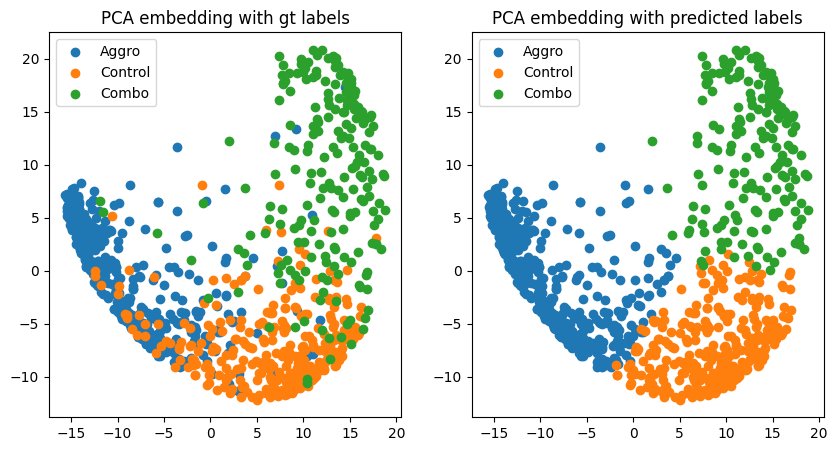

In [3]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
output_reduced = pca.fit_transform(np_outs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

aggro1 = output_reduced[np_labels == 0]
control1 = output_reduced[np_labels == 1]
combo1 = output_reduced[np_labels == 2]

ax1.scatter(aggro1[:, 0], aggro1[:, 1], label="Aggro")
ax1.scatter(control1[:, 0], control1[:, 1], label="Control")
ax1.scatter(combo1[:, 0], combo1[:, 1], label="Combo")
ax1.legend()
ax1.set_title("PCA embedding with gt labels")

aggro2 = output_reduced[np_predictions == 0]
control2 = output_reduced[np_predictions == 1]
combo2 = output_reduced[np_predictions == 2]

ax2.scatter(aggro2[:, 0], aggro2[:, 1], label="Aggro")
ax2.scatter(control2[:, 0], control2[:, 1], label="Control")
ax2.scatter(combo2[:, 0], combo2[:, 1], label="Combo")
ax2.legend()
ax2.set_title("PCA embedding with predicted labels")

plt.show()

Predicting: 100%|█████████▉| 999/1000 [04:42<00:00,  3.53it/s]


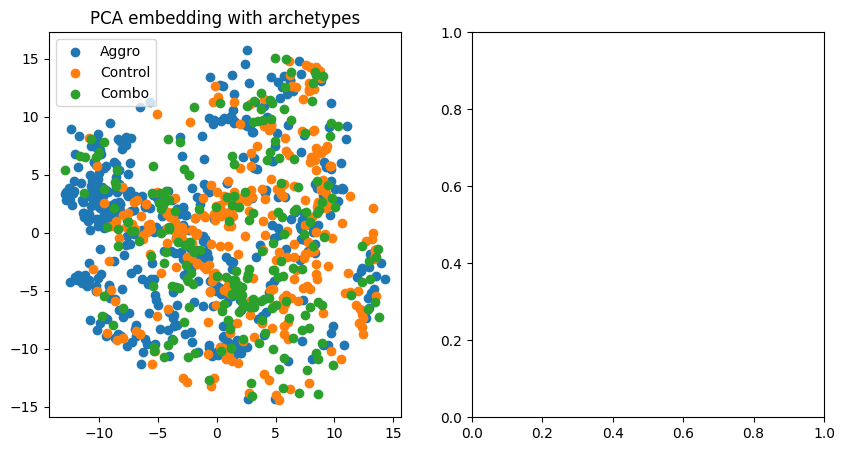

In [4]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "../models/longformer_v3"
).to("cuda")

model.eval()

outputs = []
all_labels = []
raw_texts = []
predictions = []
N = 1000
for i, batch in tqdm(enumerate(test_dataset), total=N, desc="Predicting"):
    labels = batch.pop("labels")
    raw_texts.append(batch.pop("raw_text"))
    batch = {k: torch.tensor(v).to("cuda").unsqueeze(0) for k, v in batch.items()}
    output = model(**batch, output_hidden_states=True)

    outputs.append(output.hidden_states[-1][:, 0, :].cpu().detach().numpy())
    all_labels.append(labels.cpu().detach().numpy())
    predictions.append(output.logits.cpu().detach().numpy())

    if i == N - 1:
        break

np_outs = np.concatenate(outputs)
np_labels = np.array(all_labels)
np_predictions = np.array(predictions).squeeze().argmax(axis=1)

pca = PCA(n_components=2)
output_reduced = pca.fit_transform(np_outs)

fig, ax1 = plt.subplots(1, 2, figsize=(10, 5))

aggro1 = output_reduced[np_labels == 0]
control1 = output_reduced[np_labels == 1]
combo1 = output_reduced[np_labels == 2]

ax1.scatter(aggro1[:, 0], aggro1[:, 1], label="Aggro")
ax1.scatter(control1[:, 0], control1[:, 1], label="Control")
ax1.scatter(combo1[:, 0], combo1[:, 1], label="Combo")
ax1.legend()
ax1.set_title("PCA embedding with archetypes")

plt.show()

In [5]:
import pandas as pd

raw_texts = np.array(raw_texts)
df_diffs = pd.DataFrame(
    {
        "raw_text": raw_texts,
        "gt_labels": np_labels,
        "predicted_labels": np_predictions,
    }
)

df_diffs["diff"] = df_diffs["gt_labels"] - df_diffs["predicted_labels"]

df_diffs = df_diffs[df_diffs["diff"] != 0]
df_diffs["gt_labels"] = df_diffs["gt_labels"].map(
    {0: "Aggro", 1: "Control", 2: "Combo"}
)
df_diffs["predicted_labels"] = df_diffs["predicted_labels"].map(
    {0: "Aggro", 1: "Control", 2: "Combo"}
)

In [6]:
el = df_diffs[df_diffs["predicted_labels"] == "Combo"].iloc[1]
print(f"Real label: {el['gt_labels']} - Predicted label: {el['predicted_labels']}")
el["raw_text"].split("</s>")

IndexError: single positional indexer is out-of-bounds